# **Элемент 119. ИИ в химии.**
**Отчет команды "Группа Симметрии"**

In [3]:
import pandas as pd
import numpy as np
from rapidfuzz.distance import Levenshtein
import re

from sklearn.model_selection import train_test_split

import lightgbm as lgb
import shap

from unimol_tools import MolPredict, MolTrain, UniMolRepr

from rdkit import Chem
from rdkit.Chem import AllChem, MolFromSmiles, MolFromSmarts, MolToSmiles, rdMolDescriptors
from rdkit.Chem import Descriptors, Descriptors3D, rdEHTTools
from rdkit import RDLogger
from rdkit.Chem.Scaffolds import MurckoScaffold

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
RDLogger.DisableLog('rdApp.*')   

/home/egor/Programs/miniforge3/envs/sibur/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Исследование данных

In [4]:
test_data = pd.read_csv('data/final_test_data80.csv')
train_data = pd.read_csv('data/final_train_data80.csv')

Построим гистограмму распределения LogP:

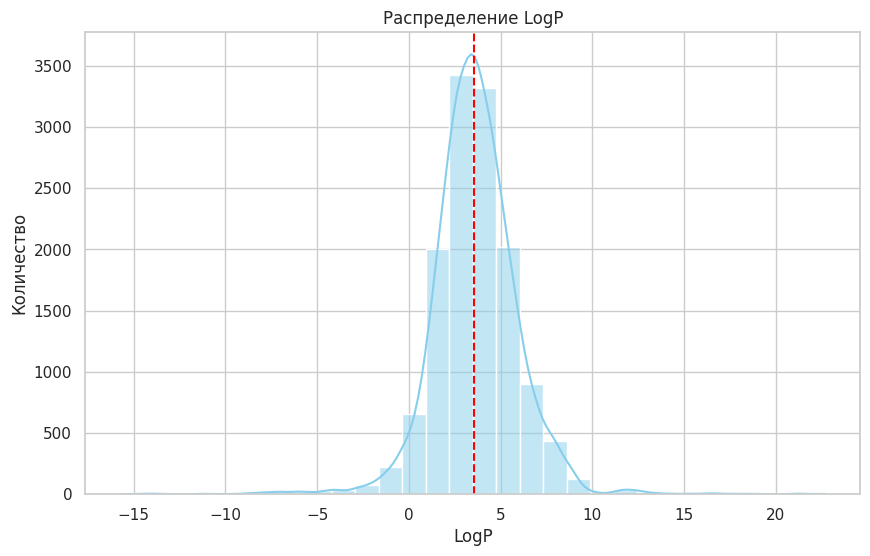

Медиана = 3.56, Дисперсия = 5.43


In [4]:
median_logp = train_data['LogP'].median()
var_logp = train_data['LogP'].var()

sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.histplot(train_data['LogP'], bins=30, kde=True, color='skyblue')
plt.axvline(median_logp, color='red', linestyle='--')

plt.title('Распределение LogP')
plt.xlabel('LogP')
plt.ylabel('Количество')
plt.show()

print(f"Медиана = {median_logp:.2f}, Дисперсия = {var_logp:.2f}")

Найдем наиболее часто встрчающиеся скаффолды:

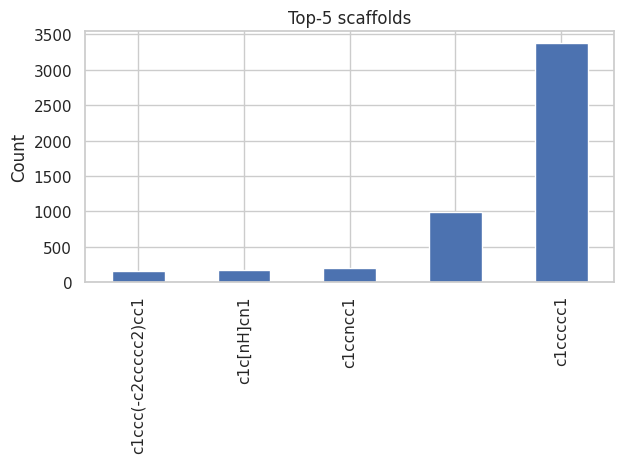

c1ccccc1               3375
                        986
c1ccncc1                204
c1c[nH]cn1              176
c1ccc(-c2ccccc2)cc1     159
Name: SMILES, dtype: int64

In [5]:
def get_scaffold(smile):
    """
    Вычисляет Murcko scaffold для заданного SMILES.
    Если SMILES некорректен, возвращает None.
    """
    mol = Chem.MolFromSmiles(smile)
    if mol is None:
        return None
    try:
        scaffold = MurckoScaffold.GetScaffoldForMol(mol)
        scaffold_smiles = Chem.MolToSmiles(scaffold)
        return scaffold_smiles
    except Exception:
        return "Error"

def analyze_top_scaffolds(smiles, top_n=10):
    """
    Определяет scaffold для каждого SMILES,
    выбирает топ-N наиболее распространённых scaffolds и строит
    столбчатую диаграмму их распределения.
    """
    
    scaffolds = smiles.apply(get_scaffold)
    
    scaffold_counts = scaffolds.value_counts()
    top_scaffolds = scaffold_counts.head(top_n)
    
    ax = top_scaffolds.sort_values(ascending=True).plot.bar()
    ax.set_ylabel("Count")
    ax.set_title(f"Top-{top_n} scaffolds")
    
    plt.tight_layout()
    plt.show()
    
    return top_scaffolds

analyze_top_scaffolds(train_data['SMILES'], top_n=5)

Видим, что молекулы в обучающем датасете содержат большое количество бензольных колец. Сравним распределения ароматических и неароматических соединений:

Aromatic соединения: Медиана = 3.62, Дисперсия = 3.50
Non-Aromatic соединения: Медиана = 2.77, Дисперсия = 4.24


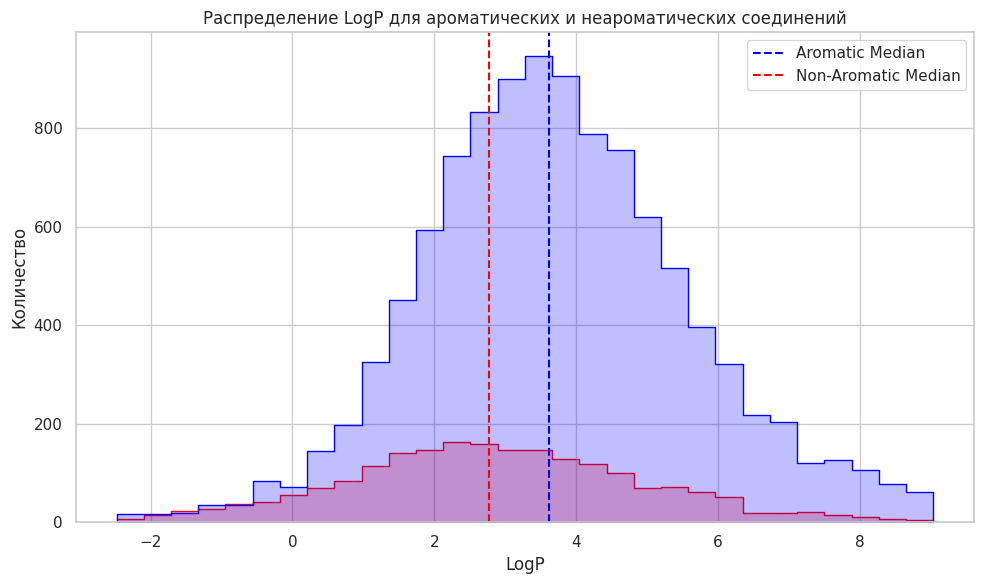

In [6]:
lower = train_data['LogP'].quantile(0.01)
upper = train_data['LogP'].quantile(0.99)
train_data = train_data[(train_data['LogP'] >= lower) & (train_data['LogP'] <= upper)]

def is_aromatic(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    return any(atom.GetIsAromatic() for atom in mol.GetAtoms())

train_data['is_aromatic'] = train_data['SMILES'].apply(is_aromatic)
train_data = train_data[train_data['is_aromatic'].notna()]

train_data['Aromaticity'] = train_data['is_aromatic'].map({True: 'Aromatic', False: 'Non-Aromatic'})

stats = train_data.groupby('Aromaticity')['LogP'].agg(['median', 'var']).reset_index()

for index, row in stats.iterrows():
    print(f"{row['Aromaticity']} соединения: Медиана = {row['median']:.2f}, Дисперсия = {row['var']:.2f}")

plt.figure(figsize=(10, 6))
sns.histplot(data=train_data, x='LogP', hue='Aromaticity', element='step', stat='count', bins=30, palette=['blue', 'red'])

for index, row in stats.iterrows():
    plt.axvline(row['median'], linestyle='--', label=f"{row['Aromaticity']} Median", color='blue' if row['Aromaticity'] == 'Aromatic' else 'red')

plt.title('Распределение LogP для ароматических и неароматических соединений')
plt.xlabel('LogP')
plt.ylabel('Количество')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Ароматические соединения обладают меньшей дисперсией чем полный датасет, а также меньшей дисперсией, чем неароматические.

Удалим выбросы, ориентируясь на интерквартильный размах. В итоговый обучающий датасет попадут молекулы с LogP между -1.2 и 8.3.

In [ ]:
def get_canonical_smiles(smi):
    try:
        mol = Chem.MolFromSmiles(smi)
        if mol is None:
            return None
        return Chem.MolToSmiles(mol, canonical=True)
    except Exception:
        return None

def classify_molecule(mol):
    if rdMolDescriptors.CalcNumAromaticRings(mol) > 0:
        return 'Aromatic'
    if mol.HasSubstructMatch(Chem.MolFromSmarts('[CX3](=O)[OX1H0-,OX2H1]')) or \
       mol.HasSubstructMatch(Chem.MolFromSmarts('[CX3](=O)[SX4](=O)=O')) or \
       mol.HasSubstructMatch(Chem.MolFromSmarts('[PX4](=O)(O)(O)')):
        return 'Acid'
    if mol.HasSubstructMatch(Chem.MolFromSmarts('[NX3]([CX4])[CX4]')) or \
       mol.HasSubstructMatch(Chem.MolFromSmarts('[NX3]([CX4])[CX4][CX4]')) or \
       mol.HasSubstructMatch(Chem.MolFromSmarts('[NX3]')):
        return 'Amine'
    if mol.HasSubstructMatch(Chem.MolFromSmarts('[CX4H2][CX4H2][CX4H2][CX4H2]')):
        return 'Alkane'
    if mol.HasSubstructMatch(Chem.MolFromSmarts('[CX3](F)(F)F')) or \
       mol.HasSubstructMatch(Chem.MolFromSmarts('[CX3](Cl)(Cl)Cl')) or \
       mol.HasSubstructMatch(Chem.MolFromSmarts('[CX3](Br)(Br)Br')):
        return 'Trihalide'
    return 'Other'

def process_smiles(smi):
    mol = Chem.MolFromSmiles(smi)
    if mol is None:
        return None, None
    mol_weight = Descriptors.MolWt(mol)
    chem_class = classify_molecule(mol)
    return mol_weight, chem_class

train_data[['mol_weight', 'chem_class']] = train_data['SMILES'].apply(
    lambda smi: pd.Series(process_smiles(smi))
)

train_data = train_data.dropna(subset=['mol_weight', 'LogP', 'chem_class'])

class_counts = train_data['chem_class'].value_counts()

train_data_clean = train_data.copy()

train_data_clean.loc[:, 'canonical_smiles'] = train_data_clean['SMILES'].apply(get_canonical_smiles)

train_data_clean = train_data_clean[train_data_clean['canonical_smiles'].notnull()].copy()

train_data_clean.loc[:, 'LogP'] = pd.to_numeric(train_data_clean['LogP'], errors='coerce')
train_data_clean = train_data_clean[train_data_clean['LogP'].notnull()].copy()

print("Количество строк после очистки от невалидных SMILES:", len(train_data_clean))

train_data_grouped = train_data_clean.groupby('canonical_smiles').agg(
    SMILES = ('SMILES', 'first'),
    LogP = ('LogP', 'mean'),
    count = ('LogP', 'count')
).reset_index(drop=True)

print("Количество уникальных молекул после группировки:", len(train_data_grouped))

Q1 = train_data_grouped['LogP'].quantile(0.25)
Q3 = train_data_grouped['LogP'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
train_data_final = train_data_grouped[(train_data_grouped['LogP'] >= lower_bound) & (train_data_grouped['LogP'] <= upper_bound)].copy()

print("Количество молекул после удаления выбросов:", len(train_data_final))
train_data_final[['SMILES', 'LogP']].to_csv('data/train_filtred.csv', index=False)

Количество строк после очистки от невалидных SMILES: 12695
Количество уникальных молекул после группировки: 10790
Количество молекул после удаления выбросов: 10664


В исходных данных обнаружено 1864 дубликатов SMILES. Чтобы устранить переобучения модели на идентичных молекулах, значения LogP были усреднены. В дальнейшем использовался более усовершенствованная методика. Группа дубликатов выделялась в отдельный датасет, и на оставшейся части обучалась модель (использовался пакет chemprop), которую использовали для предсказания LogP у дубликатов. На последнем этапе проходило сравнение предсказнного значения с имеющимися в датасете и присваивалось то, что ближе к предсказанному.

# Восстановление неправильных SMILES

In [ ]:
def canonicalize(smiles):
    m = MolFromSmiles(smiles)
    if m is None:
        return None
    else:
        return MolToSmiles(m)
        
test = pd.read_csv('data/final_test_data80.csv')
train = pd.read_csv('data/final_train_data80.csv')
test['Canonical SMILES'] = test['SMILES'].apply(canonicalize)
train['Canonical SMILES'] = train['SMILES'].apply(canonicalize)

In [32]:
n_errors = train['Canonical SMILES'].isna().sum()

print(f'Количество неправильных SMILES: {n_errors}')

Количество неправильных SMILES: 450


В датасете для обучения находится довольно много SMILES с ошибками. Посмотрим на эти SMILES:

In [33]:
errors = train.loc[train['Canonical SMILES'].isna()].copy()
correct = pd.concat([train.dropna(), test])

errors.head(10)

ID                                             SMILES   LogP  \
13    13             CC(C)MC1=C(C(N=C2NNN=N2)=O)SC(OC)=C1Br  3.919   
107  107                      C1CCCCC12C(=O)N(C(NC2=O)=O)=C  3.236   
113  113                         C(=O)(C)NC1=CC(=CC=C1=C)OC  3.839   
158  158                                         N(C(N=S)CC  2.842   
162  162  C1=CC2(C3C(CC4(C)CmO)(C(=O)CO)CCC4C3CCC2=CC1=O...  4.656   
163  163       CC(C)C(C(=O)O)NC(=O)C(C(C(C)C)#C)NC(C(C)N)=O  3.245   
222  222   N1=C(C(=NC=C1)C2=C(#C)C=C(C)C=C2)C=3C=CC(C)=CC=3  7.106   
243  243                           C=C1=C(O)C(=CC=C1)C(C)=O  4.875   
309  309                         C1(=CC=CC=C1)C(=O)C=CCO)=O  5.014   
345  345                   CC(C)CC(=O)NC=1C=C(Cl)r(=CC=1)Cl  6.896   

    Canonical SMILES  
13              None  
107             None  
113             None  
158             None  
162             None  
163             None  
222             None  
243             None  
309             None  
345             None

Внимательно изучив ошибки, можно заметить, что в большинстве случаев они представляют собой замену одного-двух знаков на случайный химический символ или случайную букву. 

В связи с этим, возникла идея сгенерировать искусственные ошибки и обучить отдельную модель предсказывать место ошибки и символ, который нужно вставить или изменить. Однако, используя такой подход, удалось восстановить лишь 53% неправильных SMILES. 

Гораздо лучше показала себя следующая методика: для каждого неправильного SMILES искать ближайших соседей среди правильных, которые ближе всего к ним по расстоянию Левенштейна.

In [34]:
# regex, который мэтчит химические элементы и символы
symbols = re.compile(r'(\[[^\]]+]|Br?|Cl?|N|O|S|P|F|I|b|c|n|o|s|p|\(|\)|\.|=|#|-|\+|\\\\|\\|\/|:|~|@|\?|>|\*|\$|\%[0-9]{2}|[0-9])')

def tokenize_smiles(smiles: str) -> list:
    '''
    Разбивает SMILES на корректные токены
    '''
    return symbols.findall(smiles)

def find_closest_rapidfuzz(errors: pd.Series, correct: pd.Series):
    '''
    Находит к каждому SMILES из errors наиболее 
    близкий по расстоянию Левенштейна SMILES из correct
    '''
    errors_list = errors.tolist()
    correct_list = correct.tolist()
    closest = []

    for i, s1 in enumerate(errors_list):
        min_dist = float('inf')
        closest_match = None
        for j, s2 in enumerate(correct_list):
            tokens1 = tokenize_smiles(s1)
            tokens2 = tokenize_smiles(s2)
            dist = Levenshtein.distance(tokens1, tokens2)
            if dist < min_dist:
                min_dist = dist
                closest_match = j
        closest.append((closest_match, min_dist))

    return zip(*closest)

errors['closest'], errors['dist'] = find_closest_rapidfuzz(errors['SMILES'], correct['SMILES'])

Text(0, 0.5, 'Count')

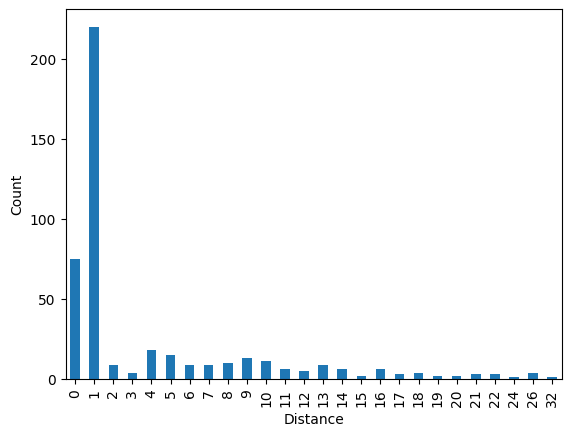

In [55]:
ax = errors['dist'].value_counts().sort_index().plot.bar()
ax.set_xlabel('Distance')
ax.set_ylabel('Count')

Как видно по полученному распределению, большинство неправильных SMILES имеет соседей на расстоянии 0 или 1 (расстояние считается только по корректным токенам). Такие SMILES мы заменяем на своих соседей, предполагая, что символ, в котором они отличаются - либо ошибка, либо не вносит значительного вклада в LogP.

In [ ]:
fixed_data = errors[errors['dist'] <= 1].copy()
fixed_data['SMILES'] = fixed_data['closest'].apply(lambda i: correct['SMILES'].iloc[i])
fixed_data = fixed_data.drop(['closest', 'dist'], axis=1)

train = train.dropna()

# Визуализация химического пространства

Было бы интересно посмотреть, на полный список всех классов соединений входящих в наш датасет, насколько тестовые данные отличаются от обучающих, а также, остались ли в данных какие-нибудь выбросы.

Для этого воспользуемся эмбеддингами, полученными с помощью модели Uni-Mol.

In [ ]:
from unimol_tools import UniMolRepr

rep = UniMolRepr(
    data_type='molecule',
    remove_hs=True,
    use_cuda=True
)

train_repr = rep.get_repr(train_data['SMILES'].to_list())
test_repr = rep.get_repr(test_data['SMILES'].to_list())
fixed_repr = rep.get_repr(fixed_data['SMILES'].to_list())

2025-04-22 18:08:22 | unimol_tools/models/unimol.py | 135 | INFO | Uni-Mol Tools | Loading pretrained weights from /home/egor/Programs/miniforge3/envs/sibur/lib/python3.11/site-packages/unimol_tools/weights/mol_pre_no_h_220816.pt
2025-04-22 18:08:27 | unimol_tools/data/conformer.py | 150 | INFO | Uni-Mol Tools | Start generating conformers...
12953it [02:57, 73.03it/s] 
2025-04-22 18:11:24 | unimol_tools/data/conformer.py | 161 | INFO | Uni-Mol Tools | Succeeded in generating conformers for 100.00% of molecules.
2025-04-22 18:11:25 | unimol_tools/data/conformer.py | 178 | INFO | Uni-Mol Tools | Succeeded in generating 3d conformers for 99.87% of molecules.
2025-04-22 18:11:25 | unimol_tools/data/conformer.py | 187 | INFO | Uni-Mol Tools | Failed 3d conformers indices: [2003, 2676, 2691, 2823, 2846, 3981, 4334, 5642, 5881, 6911, 7199, 7567, 7572, 8464, 9550, 9881, 11529]
2025-04-22 18:11:25 | unimol_tools/tasks/trainer.py | 101 | INFO | Uni-Mol Tools | Using CPU.
100%|██████████| 405/40

Воспользуемся UMAP для понижения размерности и визуализации:

In [58]:
import umap

mapper = umap.UMAP(n_jobs=4, n_neighbors=7, metric='euclidean', random_state=42, min_dist=0.5)

X_train = np.array(train_repr['cls_repr'])
X_test = np.array(test_repr['cls_repr'])
X_fixed = np.array(fixed_repr['cls_repr'])

X_train_map = mapper.fit_transform(X_train)
X_test_map = mapper.transform(X_test)
X_fixed_map = mapper.transform(X_fixed)

Отфильтруем молекулы по наличию определенных фрагментов, числу атомов и наличию '.' в SMILES (объяснение ниже).

In [ ]:
fragments = [
    MolFromSmarts('c1c(I)cc(I)cc1'),
    MolFromSmarts('nc(=O)n(O)c(=O)'),
    MolFromSmarts('cC#Cc'),
    MolFromSmarts('C1CCCCCC1O'),
    MolFromSmarts('c1cccc1S(=O)(=O)O'),
    MolFromSmarts('s1cccc1c2sc(cc2)c3sccc3'),
    MolFromSmarts('c1csn(c2ccccc2)c(=O)1')
]

def filter_smi(smi):
    if '.' in smi: return True

    mol = MolFromSmiles(smi)
    if mol:
        if mol.GetNumAtoms() > 47:
            return True

        for f in fragments:
            if mol.HasSubstructMatch(f):
                return True
        
    return False

train_data = pd.read_csv('data/train_filtred.csv')
df_filtered = train_data[~train_data['SMILES'].apply(filter_smi)]
df_filtered.to_csv('data/train_filtred_unimap.csv', index=False)
filtered = train_data['SMILES'].apply(filter_smi).to_numpy()

Используем bokeh для создания графика с изображениями молекул и интерактивной легендой

In [59]:
from bokeh.models import ColumnDataSource
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
from bokeh.resources import INLINE
from bokeh.models import LinearColorMapper, ColorBar

output_notebook(INLINE)

import bokehmol

bokehmol.register_alias()

outliers = (train_data['LogP'] > 10) | (train_data['LogP'] < -2.9)

source_train = ColumnDataSource(
    data={
    'x': X_train_map[~outliers & ~filtered, 0],
    'y': X_train_map[~outliers & ~filtered, 1],
    'color': train_data['LogP'][~outliers & ~filtered],
    'SMILES': train_data['SMILES'][~outliers & ~filtered],
    'id': list(train_data[~outliers & ~filtered].index)
    }
)

source_train_filtered = ColumnDataSource(
    data={
    'x': X_train_map[~outliers & filtered, 0],
    'y': X_train_map[~outliers & filtered, 1],
    'color': train_data['LogP'][~outliers & filtered],
    'SMILES': train_data['SMILES'][~outliers & filtered],
    'id': list(train_data[~outliers & filtered].index)
    }
)

source_test = ColumnDataSource(
    data={
    'x': X_test_map[:, 0],
    'y': X_test_map[:, 1],
    'SMILES': test_data['SMILES'],
    'id': list(test_data.index)
    }
)


source_fixed = ColumnDataSource(
    data={
    'x': X_fixed_map[:, 0],
    'y': X_fixed_map[:, 1],
    'SMILES': fixed_data['SMILES'],
    'color': fixed_data['LogP'],
    'id': list(fixed_data.ID)
    }
)

cmap = LinearColorMapper(palette='Magma256', low=-3, high=10)

plot = figure(
    width=900, height=600,
    tools="pan,wheel_zoom",
)

mol_hover = bokehmol.hover.rdkit(
    width=70, height=70, tooltips=[('LogP', '@color'), ('id', '@id')]
)

plot.add_tools(mol_hover)
plot.scatter('x', 'y', color={'field': 'color', 'transform': cmap}, source=source_train, size=4, legend_label='train')
plot.scatter('x', 'y', color={'field': 'color', 'transform': cmap}, source=source_train_filtered, size=4, legend_label='filtered')
plot.scatter('x', 'y', color='mediumspringgreen', source=source_test, size=2, legend_label='test')
plot.scatter('x', 'y', color={'field': 'color', 'transform': cmap}, source=source_fixed, size=4, legend_label='fixed')

plot.legend.click_policy = 'hide'
color_bar = ColorBar(color_mapper=cmap, width=10)

plot.add_layout(color_bar, 'right')
show(plot)

Loading BokehJS ...

При такой визуализации сразу же бросаются в глаза удаленные от центра группы молекул, не входящие в тест, а также довольно большой "остров", в который попали SMILES, содержащие несколько молекул. Мы решили, что такие SMILES лучше отфильтровать, так как они слишком отличаются от остальных, чтобы модель больше фокусировалась на данных, похожоих на тестовые.

Исходя из различия распределений для различных классов молекул, было решено создать ансамбль из моделей, обученных на различных группах молекул из датасета. При обработке новой молекулы, она классифицируется и подбирается соответствующая модель для точного предсказания её свойств. Далее мы внимательнее смотрим на ароматические молекулы и фильтруем их от выбросов.

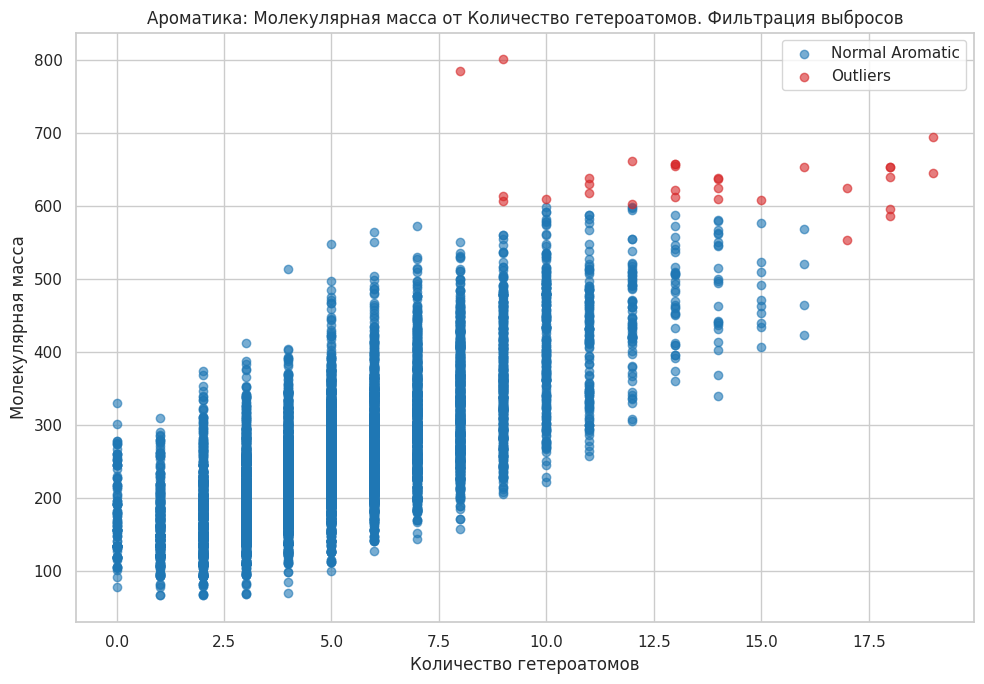

In [ ]:
def is_aromatic(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return False
    return any(atom.GetIsAromatic() for atom in mol.GetAtoms())

def calc_props(smi):
    mol = Chem.MolFromSmiles(smi)
    if mol is None:
        return None, None
    mw = Descriptors.MolWt(mol)
    n_hetero = sum(1 for atom in mol.GetAtoms() if atom.GetSymbol() not in ['C', 'H'])
    return mw, n_hetero

data = pd.read_csv('data/train_filtred_unimap.csv')

data['is_aromatic'] = data['SMILES'].apply(is_aromatic)
data[['mol_weight', 'n_hetero']] = data['SMILES'].apply(lambda smi: pd.Series(calc_props(smi)))
train_aromatic = data[data['is_aromatic']].copy()

train_aromatic['filtered'] = (train_aromatic['mol_weight'] >= 600) | (train_aromatic['n_hetero'] >= 17)

normal_train_aromatic = train_aromatic[~train_aromatic['filtered']]
outliers = train_aromatic[train_aromatic['filtered']]

plt.figure(figsize=(10, 7))
plt.scatter(normal_train_aromatic['n_hetero'], normal_train_aromatic['mol_weight'],
            alpha=0.6, label='Normal Aromatic', color='tab:blue')
plt.scatter(outliers['n_hetero'], outliers['mol_weight'],
            alpha=0.6, label='Outliers', color='tab:red')
plt.xlabel('Количество гетероатомов')
plt.ylabel('Молекулярная масса')
plt.title('Ароматика: Молекулярная масса от Количество гетероатомов. Фильтрация выбросов')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

normal_train_aromatic[['SMILES', 'LogP']].to_csv('data/aromatic_data.csv', index=False)

Делаем то же самое для "малых" молекул, но с более строгими ограничениями:

In [ ]:
def calc_props(smi):
    mol = Chem.MolFromSmiles(smi)
    if mol is None:
        return None, None
    mw = Descriptors.MolWt(mol)
    n_hetero = sum(1 for atom in mol.GetAtoms() if atom.GetSymbol() not in ['C', 'H'])
    return mw, n_hetero

data = pd.read_csv('data/train_filtred_unimap.csv')

data[['mol_weight', 'n_hetero']] = data['SMILES'].apply(lambda smi: pd.Series(calc_props(smi)))

data['filtered'] = (data['mol_weight'] >= 600) | (data['n_hetero'] >= 13) 

normal_data = data[~data['filtered']]
outliers = data[data['filtered']]

normal_data[['SMILES', 'LogP']].to_csv('data/small_molecules_data.csv', index=False)

Аналогично разбиваем тест:

In [ ]:
def is_aromatic(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return False
    return any(atom.GetIsAromatic() for atom in mol.GetAtoms())

def calc_props(smi):
    mol = Chem.MolFromSmiles(smi)
    if mol is None:
        return None, None
    mw = Descriptors.MolWt(mol)
    n_hetero = sum(1 for atom in mol.GetAtoms() if atom.GetSymbol() not in ['C', 'H'])
    return mw, n_hetero

data = pd.read_csv('data/final_test_data80.csv')

data['is_aromatic'] = data['SMILES'].apply(is_aromatic)
data[['mol_weight', 'n_hetero']] = data['SMILES'].apply(lambda smi: pd.Series(calc_props(smi)))
train_aromatic = data[data['is_aromatic']].copy()

train_aromatic['filtered'] = (train_aromatic['mol_weight'] >= 600) | (train_aromatic['n_hetero'] >= 17)

normal_train_aromatic = train_aromatic[~train_aromatic['filtered']]
outliers = train_aromatic[train_aromatic['filtered']]

normal_train_aromatic[['SMILES']].to_csv('data/test_aromatic_data.csv', index=False)

In [ ]:
def calc_props(smi):
    mol = Chem.MolFromSmiles(smi)
    if mol is None:
        return None, None
    mw = Descriptors.MolWt(mol)
    n_hetero = sum(1 for atom in mol.GetAtoms() if atom.GetSymbol() not in ['C', 'H'])
    return mw, n_hetero

data = pd.read_csv('data/final_test_data80.csv')

data[['mol_weight', 'n_hetero']] = data['SMILES'].apply(lambda smi: pd.Series(calc_props(smi)))

data['filtered'] = (data['mol_weight'] >= 600) | (data['n_hetero'] >= 13) 

normal_data = data[~data['filtered']]
outliers = data[data['filtered']]

normal_data[['SMILES']].to_csv('data/test_small_molecules.csv', index=False)

# Первая модель

In [70]:
def prepare_mol(smi):
    mol = MolFromSmiles(smi, sanitize=True)
    if mol:
        mol = AllChem.AddHs(mol)
        AllChem.EmbedMolecule(mol, randomSeed=42)
        if mol and mol.GetNumConformers() > 0:
            AllChem.MMFFOptimizeMolecule(mol)
    
        return mol
    
    return None

def calc_qc_properties(s):
    mol = s['Mol']

    if mol and mol.GetNumConformers() > 0:
        _, result = rdEHTTools.RunMol(mol)

        orbitals = result.GetOrbitalEnergies()

        HOMO = orbitals[result.numElectrons // 2]
        LUMO = orbitals[result.numElectrons // 2 + 1]
        energy = result.totalEnergy
        charges = result.GetAtomicCharges()
        dipole = 0
        for pos, charge in zip(mol.GetConformer(0).GetPositions(), charges):
            dipole += pos * charge

        return HOMO, LUMO, HOMO - LUMO, energy, np.linalg.norm(dipole)

    return None, None, None, None, None

def preprocess(data):
    if not 'Mol' in data:
        data = data.dropna()
        data = data.drop_duplicates(subset='Canonical SMILES')

        data['Mol'] = data['SMILES'].apply(prepare_mol)

    X = pd.DataFrame()
    desc_names = [name for name, _ in Descriptors.descList]
    X[desc_names] = data.apply(
        lambda s: Descriptors.CalcMolDescriptors(s['Mol']).values(), 
        axis=1, 
        result_type='expand'
    )

    desc3d_names = [name for name, _ in Descriptors3D.descList]
    X[desc3d_names] = data.apply(
        lambda s: Descriptors3D.CalcMolDescriptors3D(s['Mol']) 
            if s['Mol'] and s['Mol'].GetNumConformers() else {d:None for d in desc3d_names}, 
        axis=1, 
        result_type='expand'
    )

    X[['HOMO', 'LUMO', 'Gap', 'Energy', 'Dipole']] = data.apply(
        calc_qc_properties, axis=1, result_type='expand'
    )

    y = data.get('LogP')
    
    return X, y

X_train, X_val, y_train, y_val = train_test_split(*preprocess(train_data), random_state=42)

!!! Warning !!! Distance between atoms 18 and 6 (0.972430 A) is suspicious.
!!! Warning !!! Distance between atoms 69 and 16 (0.983385 A) is suspicious.
!!! Warning !!! Distance between atoms 52 and 23 (0.969053 A) is suspicious.
!!! Warning !!! Distance between atoms 21 and 5 (0.971873 A) is suspicious.
!!! Warning !!! Distance between atoms 17 and 4 (0.975985 A) is suspicious.
!!! Warning !!! Distance between atoms 20 and 10 (0.979993 A) is suspicious.
!!! Warning !!! Distance between atoms 13 and 3 (0.971058 A) is suspicious.
!!! Warning !!! Distance between atoms 19 and 11 (0.980684 A) is suspicious.
!!! Warning !!! Distance between atoms 20 and 3 (0.980678 A) is suspicious.
!!! Warning !!! Distance between atoms 104 and 42 (0.980941 A) is suspicious.
!!! Warning !!! Distance between atoms 112 and 47 (0.981922 A) is suspicious.
!!! Warning !!! Distance between atoms 122 and 53 (0.978351 A) is suspicious.
!!! Warning !!! Distance between atoms 31 and 7 (0.892152 A) is suspicious.
!!

In [ ]:
params = {
    'objective': 'regression',
    'nthread': 8,
    'metric': 'rmse',
    'learning_rate': 0.05,
}

tr_lgb = lgb.Dataset(X_train, y_train)
val_lgb = lgb.Dataset(X_val, y_val)

model = lgb.train(params, tr_lgb, 500, [val_lgb], callbacks=[
    lgb.early_stopping(10),
    lgb.log_evaluation(100)         
])

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016949 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27326
[LightGBM] [Info] Number of data points in the train set: 9714, number of used features: 222
[LightGBM] [Info] Start training from score 3.559001
Training until validation scores don't improve for 10 rounds
[100]	valid_0's rmse: 1.58204
Early stopping, best iteration is:
[117]	valid_0's rmse: 1.57777


In [80]:
explainer = shap.TreeExplainer(model)
shap_values = explainer(X_val)

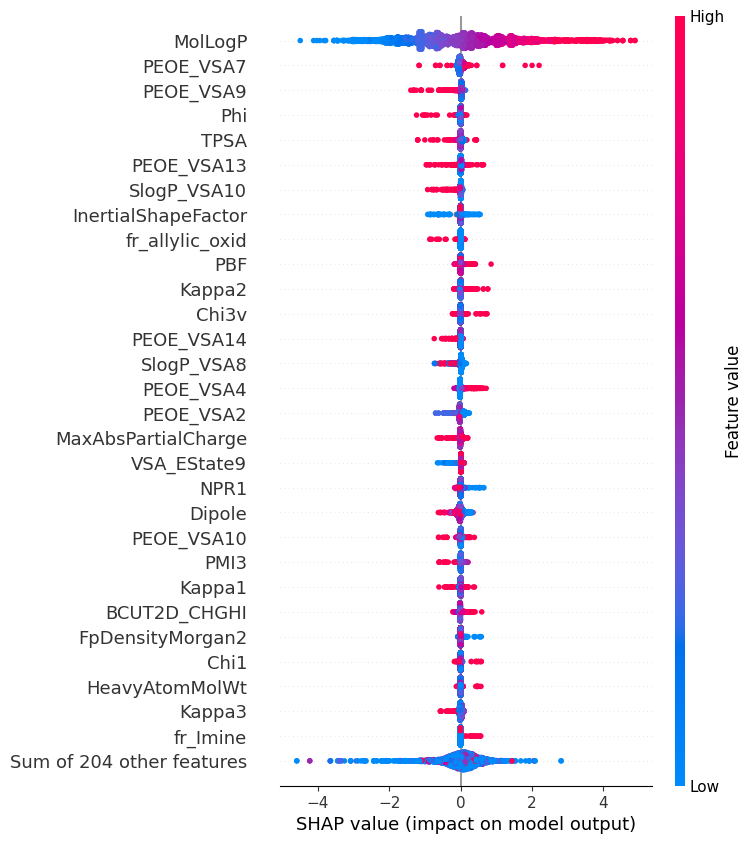

In [81]:
shap.plots.beeswarm(shap_values, max_display=30, order=shap.Explanation.abs.max(0), plot_size=(6, 10))

# Итоговое решение

В нашем решении мы использовали модель Chemprop для быстрой проверки гипотез и модель Uni-Mol для итогового предсказания. Такой выбор был сделан после сравнения предсказательной способности обеих моделей на нашем датасете.

Для Chemprop были выбраны следующие гиперпараметры:

| Параметр            | Значение   |
|---------------------|------------|
| epochs              | 50         |
| patience            | None       |
| message_hidden_dim  | 300        |
| depth               | 3          |
| ffn_hidden_dim      | 300        |
| ffn_num_layers      | 1          |
| dropout             | 0.0        |
| init_lr             | 0.0001     |
| batch_size          | 64         |
| split               | RANDOM     |
| ensemble_size       | 1          |
| num_replicates      | 1          |

Команды для запуска chemprop:

In [ ]:
!chemprop train --data-path train.csv --task-type regression --output-dir train_output

In [ ]:
!chemprop predict --test-path test.csv --model-path train_output/model_0/best.pt --preds-path predictions.csv

После анализа предсказательной способности различных пакетов, в качестве основного был выбран Uni-Mol, показавший наилучшие результаты. 

Так же была проведена настройка гиперпараметров (вручную, так как обучение занимало много времени)

| Параметр         | Значение       |
|------------------|----------------|
| epochs           | 40             |
| learning_rate    | 0.0004         |
| batch_size       | 8              |
| early_stopping   | 5              |
| smiles_col       | 'smiles'       |
| target_cols      | 'LogP'         |
| metrics          | 'mse'          |
| split            | 'random'       |

Обучение на основном датасете:

In [ ]:
clf = MolTrain(task='regression',
                data_type='molecule',
                epochs=40,
                learning_rate=0.0004,
                batch_size=8,
                early_stopping=5,
                smiles_col='SMILES',  
                target_cols='LogP',
                metrics='mse',
                split='random',
                save_path='./exp',
              )

clf.fit('data/train_filtred_unimap.csv')

In [ ]:
clf = MolPredict(load_model='./exp')
res = clf.predict('data/final_test_data80.csv')

In [ ]:
datafr_res = pd.DataFrame(data=res)
datafr_res = datafr_res.astype(str)

In [ ]:
smiles_df = pd.read_csv('data/test_smiles.csv')
datafr_res = datafr_res.reset_index(drop=True)
smiles_df = smiles_df.reset_index(drop=True)

combined = pd.DataFrame({
    'SMILES': smiles_df['SMILES'],
    'LogP':smiles_df['LogP']
})

combined.to_csv('data/big_data.csv', index=False)

Обучение на ароматических молекулах:

In [ ]:
clf = MolTrain(task='regression',
                data_type='molecule',
                epochs=40,
                learning_rate=0.0004,
                batch_size=8,
                early_stopping=5,
                smiles_col='SMILES',  
                target_cols='LogP',
                metrics='mse',
                split='random',
                save_path='./exp_n1',
              )

clf.fit('data/aromatic_data.csv')

In [ ]:
clf = MolPredict(load_model='./exp')
res = clf.predict('data/test_aromatic_data.csv')

In [ ]:
datafr_res = pd.DataFrame(data=res)
datafr_res = datafr_res.astype(str)
smiles_df = pd.read_csv('data/test_aromatic_data.csv')

datafr_res = datafr_res.reset_index(drop=True)
smiles_df = smiles_df.reset_index(drop=True)

combined = pd.DataFrame({
    'SMILES': smiles_df['SMILES'],
    'LogP':smiles_df['LogP']
})

combined.to_csv('data/aromatic_smiles.csv', index=False)

Обучение на "малых" молекулах:

In [ ]:
clf = MolTrain(task='regression',
                data_type='molecule',
                epochs=40,
                learning_rate=0.0004,
                batch_size=8,
                early_stopping=5,
                smiles_col='SMILES',  
                target_cols='LogP',
                metrics='mse',
                split='random',
                save_path='./exp_n2',
              )

clf.fit('data/small_molecules_data.csv')

In [ ]:
clf = MolPredict(load_model='./exp_n2')
res = clf.predict('data/test_small_molecules.csv')

In [ ]:
datafr_res = pd.DataFrame(data=res)
datafr_res = datafr_res.astype(str)
smiles_df = pd.read_csv('data/test_small_molecules.csv')

datafr_res = datafr_res.reset_index(drop=True)
smiles_df = smiles_df.reset_index(drop=True)

combined = pd.DataFrame({
    'SMILES': smiles_df['SMILES'],
    'LogP':smiles_df['LogP']
    
})

combined.to_csv('data/small_smiles.csv', index=False)

После обучения датасеты объединялись в следующем порядке сначала брались значения LogP из предсказанных для ароматических молекул, потом для молекул с малой молекулярной массой и среднем количеством гетероатомов. Значения молекул, не попавших ни в один датасет, брались из теста предсказанного на модели обученной на всем тренеровочном наборе.

In [ ]:
test_data = pd.read_csv('data/final_test_data80.csv')  # ID, SMILES
predictions1 = pd.read_csv('data/aromatic_smiles.csv')  # SMILES, LogP
predictions2 = pd.read_csv('data/small_smiles.csv')  # SMILES, LogP
predictions3 = pd.read_csv('data/big_data.csv')  # SMILES, LogP

merged = test_data.merge(
    predictions1[['SMILES', 'LogP']],
    on='SMILES',
    how='left'
)

merged = merged.merge(
    predictions2[['SMILES', 'LogP']],
    on='SMILES',
    how='left',
    suffixes=('_pred1', '_pred2')
)

merged = merged.merge(
    predictions3[['SMILES', 'LogP']],
    on='SMILES',
    how='left'
)

# Комбинирование значений: сначала из predictions1, затем из predictions2, затем из predictions3
merged['LogP'] = merged['LogP_pred1'].combine_first(merged['LogP_pred2']).combine_first(merged['LogP'])

result = merged[['ID', 'LogP']]

result.to_csv('data/final_predictions.csv', index=False)